In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fast_control.viz.episodic_plot import *
from fast_control.viz.animate import create_animation
from fast_control.viz.plot import *
from fast_control.controller_factory import(
    eval_cs, 
    ControllerFactory, 
    train_episodic_with_info, 
    simulate_sys
    train_gps
)
from fast_control.gp_factory import init_gp_dict
from core.systems import DoubleInvertedPendulum
import sys
import mosek
import numpy as np
import toml
np.set_printoptions(threshold=sys.maxsize)
import torch
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

ImportError: cannot import name 'init_gp_dict' from 'fast_control.controller_factory' (/home/kk983/fast_control/fast_control/controller_factory/__init__.py)

In [52]:
with open("config.toml") as f:
    config = toml.load(f)
sys_conf = config["acrobat"]
gps_names = sys_conf["gps_names"]
system = DoubleInvertedPendulum(*sys_conf["sys_params"])
system_est = DoubleInvertedPendulum(*sys_conf["sys_est_params"])
ts = np.linspace(0, sys_conf["T"], sys_conf["num_steps"])

In [8]:
def training_data_gen(self, controller, x_0=None, T=None, num_steps=None):
    """Generate training data given a controller."""
    xs, us, ts = simulate_sys(self, controller, x_0, T, num_steps)
    ys = np.concatenate((np.ones((len(us), 1)), us), axis=1)
    x_dots = np.array([system.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
    return xs[:-1], ys, x_dots

In [9]:
def create_grid_data(self, T=1, num_steps=10):
    """Initialize grided training data.

    run a grid of initial points with nominal controller for several steps
    """
    initial_x0s = (
        np.mgrid[0.1 : np.pi : 1, -1:1.1:0.4, 0 : np.pi : 1, -1:1.1:0.4]
        .reshape(4, -1)
        .T
    )
    for i, x_0 in enumerate(initial_x0s):
        if i == 0:
            xs, ys, zs = training_data_gen(
                self,
                self.system.qp_controller,
                torch.from_numpy(x_0), T, num_steps
            )
        else:
            x, y, z = training_data_gen(
                self,
                self.system.qp_controller,
                torch.from_numpy(x_0), T, num_steps
            )
            xs = np.concatenate((xs, x))
            ys = np.concatenate((ys, y))
            zs = np.concatenate((zs, z))

    x, y, z = training_data_gen(
        self, self.system.qp_controller, torch.FloatTensor([0.1, 0, 0, 0]), T, num_steps
    )
    xs = np.concatenate((xs, x))
    ys = np.concatenate((ys, y))
    zs = np.concatenate((zs, z))

    np.savez("data/init_grid_x_dot", xs=xs, ys=ys, zs=zs)
    return xs, ys, zs

In [57]:
control = ControllerFactory(system, system_est)
# xs, ys, x_dots = create_grid_data(control)

pre_data = np.load("data/init_grid_x_dot.npz")
xs, ys, x_dots = pre_data["xs"], pre_data["ys"], pre_data["x_dots"]
data = init_gp_dict(control, xs, ys, x_dots)
gps = train_gps(control, data)
print(x_dots.shape)

data size:5193, rf_d is: 578
(5193, 4)


In [62]:
def plot(preds, labels, ts, gps_names):
    
    for i in range(4):
        plt.figure()
        for gp_num,name in enumerate(gps_names):
            sns.lineplot(x=ts,y=preds[gp_num,:,i],label=name+" $\dot{x}$ prediction")
        sns.lineplot(x=ts,y=labels[:,i],color='black', linestyle='--',label="true $\dot{x}$")
   
        plt.xlabel("time")
        plt.ylabel(f"{i}-th coordinate of x_dot")
        plt.tight_layout()
        plt.legend()
        plt.savefig(f"data/50/x_dot_error_{name}.png", dpi=300)
        plt.show()
        plt.close()

ad_rf rmse is [0.01587383 0.02671074 0.05078907 0.01739334]
ad_rf mae is [0.00991091 0.02465919 0.03391711 0.01208426]
adp_rf rmse is [0.01608013 0.0103076  0.04192803 0.01547724]
adp_rf mae is [0.0126632  0.0087602  0.03742307 0.01354437]
ad_kernel rmse is [0.02072022 0.02545813 0.04662574 0.01990333]
ad_kernel mae is [0.01216933 0.02349754 0.03807661 0.01777133]
adp_kernel rmse is [0.01950213 0.01263578 0.05554891 0.0196595 ]
adp_kernel mae is [0.01357469 0.01082924 0.04854809 0.01736882]


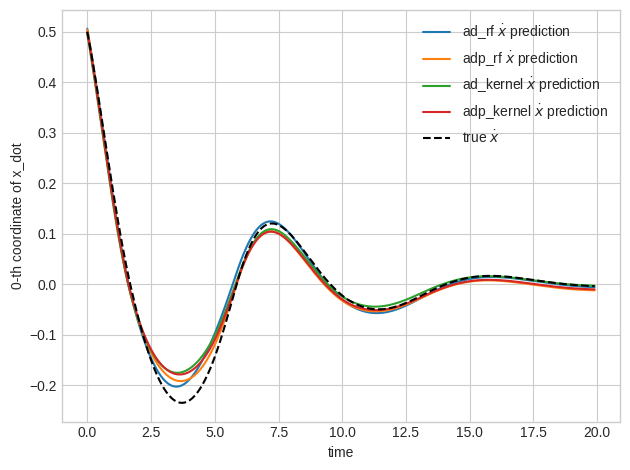

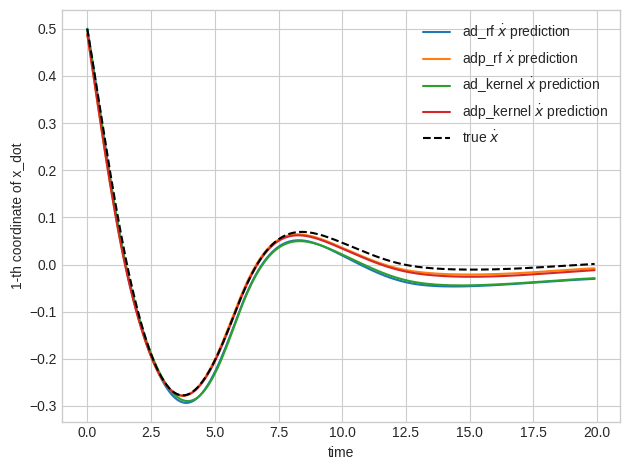

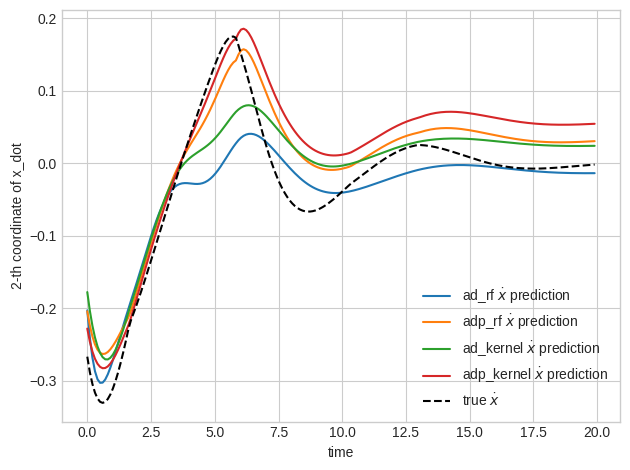

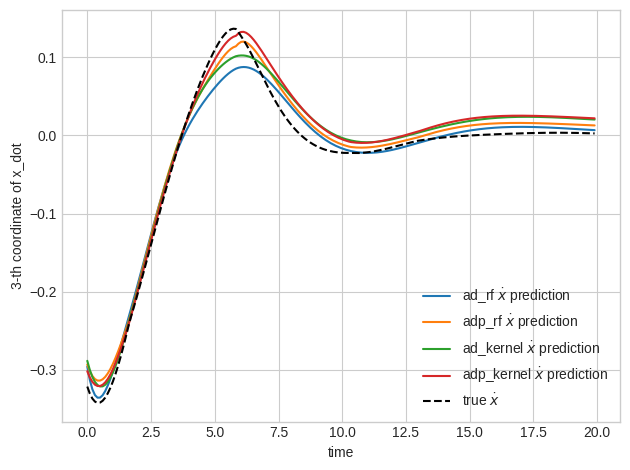

In [65]:
#test on a random point
x_test = [.5, .5, .5, .5]
xs, ys, x_dots = training_data_gen(
        control, control.system.qp_controller, torch.FloatTensor(x_test)
    )
#compute rmse and mae for each gp for each dimension of the labels on each point
#plot the error for each dimension of the labels
x_dot_preds = np.empty((len(gps), len(x_dots), 4))
for i,gp in enumerate(gps):
    x_dot_preds[i,:,:] = gp.test(xs, ys)
    rmse = mean_squared_error(x_dots, x_dot_preds[i,:,:], squared=False, multioutput='raw_values')
    mae = mean_absolute_error(x_dots, x_dot_preds[i,:,:], multioutput='raw_values')
    print(gp.name, f"rmse is {rmse}")
    print(gp.name, f"mae is {mae}")

plot(x_dot_preds, x_dots, ts[:-1], gps_names)



    
    